In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
POS_PATH=os.path.join("app","data","positive")
NEG_PATH=os.path.join("app","data","negative")
ANC_PATH=os.path.join("app","data","anchor")

In [3]:
directories = [POS_PATH,NEG_PATH,ANC_PATH]

In [4]:
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created: {directory}")
    else:
        print(f"Already exists: {directory}")

Already exists: app\data\positive
Already exists: app\data\negative
Already exists: app\data\anchor


In [5]:
dataset='https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download-directory'

In [21]:
LFW_PATH = 'lfw-deepfunneled'

for directory in os.listdir(LFW_PATH):
    person_path = os.path.join(LFW_PATH, directory)
    
    # Skip if it's not a directory
    if not os.path.isdir(person_path):
        continue

    for file in os.listdir(person_path):
        EX_PATH = os.path.join(person_path, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
        print(f"Moved {EX_PATH} to {NEW_PATH}")
        

Moved lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg to app\data\negative\Aaron_Eckhart_0001.jpg
Moved lfw-deepfunneled\Aaron_Guiel\Aaron_Guiel_0001.jpg to app\data\negative\Aaron_Guiel_0001.jpg
Moved lfw-deepfunneled\Aaron_Patterson\Aaron_Patterson_0001.jpg to app\data\negative\Aaron_Patterson_0001.jpg
Moved lfw-deepfunneled\Aaron_Peirsol\Aaron_Peirsol_0001.jpg to app\data\negative\Aaron_Peirsol_0001.jpg
Moved lfw-deepfunneled\Aaron_Peirsol\Aaron_Peirsol_0002.jpg to app\data\negative\Aaron_Peirsol_0002.jpg
Moved lfw-deepfunneled\Aaron_Peirsol\Aaron_Peirsol_0003.jpg to app\data\negative\Aaron_Peirsol_0003.jpg
Moved lfw-deepfunneled\Aaron_Peirsol\Aaron_Peirsol_0004.jpg to app\data\negative\Aaron_Peirsol_0004.jpg
Moved lfw-deepfunneled\Aaron_Pena\Aaron_Pena_0001.jpg to app\data\negative\Aaron_Pena_0001.jpg
Moved lfw-deepfunneled\Aaron_Sorkin\Aaron_Sorkin_0001.jpg to app\data\negative\Aaron_Sorkin_0001.jpg
Moved lfw-deepfunneled\Aaron_Sorkin\Aaron_Sorkin_0002.jpg to app\data\negati

In [143]:
i=0
cap=cv2.VideoCapture(0)
while cap.isOpened():
    res,frame=cap.read()
    frame = cv2.resize(frame, (250, 250))
    # if i < 300:
    #     if i%50==0:
    #         print("Saving Images")
    #     if i==299:
    #         print("Saved All")
    #     img_name=os.path.join(POS_PATH,f'Veer_{i}.jpg')
    #     cv2.imwrite(img_name,frame)
        # i+=1
    cv2.imshow("Image",frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

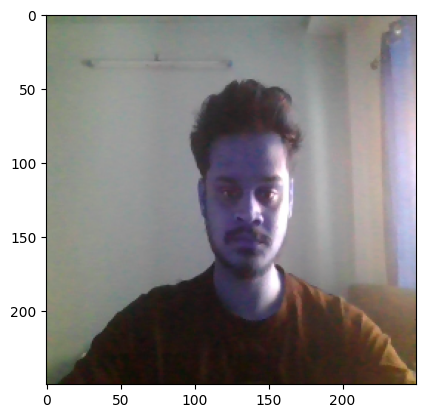

In [39]:
plt.imshow(frame[:,:,:])

In [172]:
frame.shape

(250, 250, 3)

In [6]:
import torch
import os
import random
from PIL import Image

In [7]:
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms

In [8]:
def load_images_from_folder(folder_path, max_images=300):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])[:max_images]
    images = [os.path.join(folder_path, f) for f in image_files]
    return images

In [9]:
def create_siamese_pairs(anchor_paths, positive_paths, negative_paths):
    positive_pairs = list(zip(anchor_paths, positive_paths, [1.0] * len(anchor_paths)))
    negative_pairs = list(zip(anchor_paths, negative_paths[:len(anchor_paths)], [0.0] * len(anchor_paths)))
    all_pairs = positive_pairs + negative_pairs
    random.shuffle(all_pairs)  
    return all_pairs

In [10]:
class SiameseDataset(Dataset):
    def __init__(self,pairs,apply_transforms=True):
        self.pairs=pairs
        self.transforms=transforms.Compose([
            transforms.Resize((105, 105)),
            transforms.ToTensor()
            ]) if apply_transforms else None
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
    
        img_path1,img_path2,label=self.pairs[index]
        img1 = Image.open(img_path1).convert('RGB')
        img2 = Image.open(img_path2).convert('RGB')
        
        if self.transforms:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
            
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [11]:
anchor_paths = load_images_from_folder(ANC_PATH, max_images=300)
positive_paths = load_images_from_folder(POS_PATH, max_images=300)
negative_paths = load_images_from_folder(NEG_PATH, max_images=300)
all_pairs = create_siamese_pairs(anchor_paths, positive_paths, negative_paths)
print(len(all_pairs))  

600


In [12]:
all_pairs[333]

('app\\data\\anchor\\Veer_284.jpg', 'app\\data\\positive\\Veer_284.jpg', 1.0)

In [13]:
split_idx = int(0.7 * len(all_pairs))
train_pairs = all_pairs[:split_idx]
test_pairs = all_pairs[split_idx:]

In [14]:
train_data=SiameseDataset(train_pairs,apply_transforms=True)
test_data=SiameseDataset(test_pairs,apply_transforms=True)

In [15]:
train_data[1]

(tensor([[[0.4667, 0.4902, 0.5059,  ..., 0.6000, 0.6275, 0.6510],
          [0.4745, 0.4941, 0.5020,  ..., 0.5922, 0.6314, 0.6549],
          [0.4863, 0.4941, 0.5020,  ..., 0.6039, 0.6392, 0.6706],
          ...,
          [0.2706, 0.3020, 0.3569,  ..., 0.1843, 0.1961, 0.2510],
          [0.2902, 0.3255, 0.3490,  ..., 0.1608, 0.1529, 0.1725],
          [0.3059, 0.3412, 0.3569,  ..., 0.1412, 0.1294, 0.1490]],
 
         [[0.5804, 0.5765, 0.5843,  ..., 0.5569, 0.5608, 0.5608],
          [0.5843, 0.5843, 0.5843,  ..., 0.5490, 0.5608, 0.5647],
          [0.5961, 0.5843, 0.5843,  ..., 0.5490, 0.5686, 0.5725],
          ...,
          [0.3451, 0.3804, 0.4627,  ..., 0.3255, 0.3686, 0.4510],
          [0.3765, 0.4157, 0.4471,  ..., 0.2980, 0.3137, 0.3529],
          [0.3882, 0.4275, 0.4471,  ..., 0.2824, 0.2824, 0.3098]],
 
         [[0.5490, 0.5451, 0.5490,  ..., 0.5529, 0.5882, 0.6118],
          [0.5490, 0.5490, 0.5490,  ..., 0.5569, 0.5922, 0.6118],
          [0.5529, 0.5451, 0.5490,  ...,

In [16]:
test_data[1]

(tensor([[[0.5059, 0.4863, 0.4706,  ..., 0.5882, 0.6235, 0.6471],
          [0.4980, 0.4902, 0.4824,  ..., 0.5804, 0.6157, 0.6471],
          [0.5020, 0.4980, 0.4941,  ..., 0.5804, 0.6235, 0.6549],
          ...,
          [0.2745, 0.3059, 0.3529,  ..., 0.1843, 0.2941, 0.4392],
          [0.2863, 0.3333, 0.3451,  ..., 0.1451, 0.2078, 0.3647],
          [0.2824, 0.3529, 0.3529,  ..., 0.1294, 0.1647, 0.3255]],
 
         [[0.5843, 0.5882, 0.5882,  ..., 0.5529, 0.5647, 0.5686],
          [0.5765, 0.5882, 0.5961,  ..., 0.5529, 0.5647, 0.5725],
          [0.5843, 0.5843, 0.5922,  ..., 0.5569, 0.5725, 0.5725],
          ...,
          [0.3608, 0.4078, 0.4863,  ..., 0.3686, 0.4980, 0.6510],
          [0.3882, 0.4353, 0.4627,  ..., 0.3098, 0.4039, 0.5922],
          [0.3843, 0.4471, 0.4549,  ..., 0.2667, 0.3412, 0.5529]],
 
         [[0.5373, 0.5137, 0.5294,  ..., 0.5451, 0.5686, 0.5843],
          [0.5294, 0.5333, 0.5412,  ..., 0.5451, 0.5725, 0.5882],
          [0.5333, 0.5608, 0.5529,  ...,

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [18]:
first_batch = next(iter(train_loader))
img1, img2, label = first_batch

In [19]:
print(img1.shape)  
print(img2.shape)
print(label)   

torch.Size([16, 3, 105, 105])
torch.Size([16, 3, 105, 105])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.])


In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = F.relu(self.conv4(x))              
        x = x.view(x.size(0), -1)             
        x = torch.sigmoid(self.fc1(x))         
        return x

In [22]:
class FinalLayer(nn.Module):
    def __init__(self):
        super(FinalLayer,self).__init__()
        self.linear=nn.Linear(4096,1)
    
    def forward(self,x):
        x=torch.sigmoid(self.linear(x))
        return x

In [23]:
def compute_l1_distance(anchor_embeddings,validation_embeddings):
    l1_distance = torch.abs(anchor_embeddings - validation_embeddings)
    return l1_distance


In [54]:
print(torch.cuda.is_available())

True


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
first_batch = next(iter(train_loader))
print((first_batch[1]))

tensor([[[[0.4588, 0.4745, 0.4863,  ..., 0.5647, 0.6157, 0.6588],
          [0.4667, 0.4784, 0.4824,  ..., 0.5647, 0.6157, 0.6549],
          [0.4784, 0.4824, 0.4824,  ..., 0.5686, 0.6196, 0.6510],
          ...,
          [0.2784, 0.2902, 0.3373,  ..., 0.4706, 0.4745, 0.4510],
          [0.2902, 0.3176, 0.3255,  ..., 0.4863, 0.4863, 0.5020],
          [0.2980, 0.3294, 0.3333,  ..., 0.5255, 0.5412, 0.5843]],

         [[0.5647, 0.5725, 0.5725,  ..., 0.5176, 0.5255, 0.5255],
          [0.5647, 0.5686, 0.5725,  ..., 0.5333, 0.5490, 0.5490],
          [0.5686, 0.5647, 0.5686,  ..., 0.5412, 0.5608, 0.5647],
          ...,
          [0.3529, 0.3843, 0.4471,  ..., 0.5686, 0.5882, 0.5843],
          [0.3608, 0.4078, 0.4275,  ..., 0.5686, 0.5843, 0.6196],
          [0.3608, 0.4157, 0.4314,  ..., 0.6039, 0.6353, 0.6980]],

         [[0.4980, 0.4706, 0.4824,  ..., 0.5451, 0.5529, 0.5686],
          [0.5059, 0.4980, 0.5059,  ..., 0.5490, 0.5647, 0.5725],
          [0.5176, 0.5333, 0.5294,  ..., 0

In [56]:
embedding_model = SiameseNeuralNetwork()
final_layer = FinalLayer()

In [58]:
embedding_model.to(device)

SiameseNeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
)

In [59]:
embedding_model.to(device)
final_layer.to(device)

FinalLayer(
  (linear): Linear(in_features=4096, out_features=1, bias=True)
)

In [61]:
optimizer = torch.optim.Adam(list(embedding_model.parameters()) + list(final_layer.parameters()), lr=1e-4)
criterion = nn.BCELoss()

In [62]:
epochs=100
for epoch in range(epochs):
    embedding_model.train()
    final_layer.train()
    total_loss = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        anchor_out = embedding_model(img1)      
        paired_out = embedding_model(img2)      
        distance = compute_l1_distance(anchor_out, paired_out) 

        pred = final_layer(distance).squeeze() 
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/100, Loss: 10.7453
Epoch 2/100, Loss: 2.9752
Epoch 3/100, Loss: 1.6925
Epoch 4/100, Loss: 0.8581
Epoch 5/100, Loss: 0.3758
Epoch 6/100, Loss: 0.2906
Epoch 7/100, Loss: 0.4320
Epoch 8/100, Loss: 0.4905
Epoch 9/100, Loss: 1.4141
Epoch 10/100, Loss: 0.6413
Epoch 11/100, Loss: 0.2664
Epoch 12/100, Loss: 0.1612
Epoch 13/100, Loss: 0.0822
Epoch 14/100, Loss: 0.0669
Epoch 15/100, Loss: 0.0553
Epoch 16/100, Loss: 0.0465
Epoch 17/100, Loss: 0.0399
Epoch 18/100, Loss: 0.0322
Epoch 19/100, Loss: 0.0270
Epoch 20/100, Loss: 0.0248
Epoch 21/100, Loss: 0.0251
Epoch 22/100, Loss: 0.0237
Epoch 23/100, Loss: 0.0249
Epoch 24/100, Loss: 0.0182
Epoch 25/100, Loss: 0.0156
Epoch 26/100, Loss: 0.0141
Epoch 27/100, Loss: 0.0150
Epoch 28/100, Loss: 0.0123
Epoch 29/100, Loss: 0.0109
Epoch 30/100, Loss: 0.0099
Epoch 31/100, Loss: 0.0101
Epoch 32/100, Loss: 0.0091
Epoch 33/100, Loss: 0.0083
Epoch 34/100, Loss: 0.0074
Epoch 35/100, Loss: 0.0070
Epoch 36/100, Loss: 0.0108
Epoch 37/100, Loss: 0.0077
Epoch 38/

In [63]:
embedding_model.eval()
final_layer.eval()

total_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        out1 = embedding_model(img1)
        out2 = embedding_model(img2)

        distance = compute_l1_distance(out1, out2)
        pred = final_layer(distance).squeeze()

        loss = criterion(pred, label)
        total_loss += loss.item()

        pred_label = (pred > 0.5).float()
        correct += (pred_label == label).sum().item()
        total += label.size(0)

average_loss = total_loss / len(test_loader)
accuracy = correct / total * 100

print(f"\nTest Loss: {average_loss:.4f}")
print(f"\nTest Accuracy: {accuracy:.2f}%")



Test Loss: 0.0001

Test Accuracy: 100.00%


In [67]:
import cv2
import torch
import os
import random
from torchvision import transforms
from PIL import Image

# === 1. Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
embedding_model.eval()
final_layer.eval()
embedding_model.to(device)
final_layer.to(device)

# Transform for input images
transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
])

# Load positive images
POS_PATH = "app/data/positive"  # make sure this is your correct path
pos_files = [os.path.join(POS_PATH, f) for f in os.listdir(POS_PATH) if f.endswith('.jpg')]

# === 2. Define L1 distance ===
def compute_l1_distance(emb1, emb2):
    return torch.abs(emb1 - emb2)

# === 3. Compare webcam image to multiple positive images ===
def is_match(input_tensor, threshold=0.5, sample_count=5, vote_required=3):
    match_count = 0
    with torch.no_grad():
        for pos_path in random.sample(pos_files, sample_count):
            pos_img = Image.open(pos_path).convert("RGB")
            pos_tensor = transform(pos_img).unsqueeze(0).to(device)

            emb1 = embedding_model(input_tensor)
            emb2 = embedding_model(pos_tensor)
            dist = compute_l1_distance(emb1, emb2)
            pred = final_layer(dist).item()

            if pred > threshold:
                match_count += 1

    return match_count >= vote_required

# === 4. Start webcam and prediction loop ===
cap = cv2.VideoCapture(0)

while cap.isOpened():
    res, frame = cap.read()
    if not res:
        break

    frame_resized = cv2.resize(frame, (250, 250))
    cv2.imshow("Press 'p' to Predict, 'q' to Quit", frame_resized)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('p'):
        # Convert webcam frame to tensor
        input_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).resize((105, 105))
        input_tensor = transform(input_pil).unsqueeze(0).to(device)

        match = is_match(input_tensor)

        print("MATCH ✅" if match else "NO MATCH ❌")

    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
NO MATCH ❌
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
MATCH ✅
NO MATCH ❌
NO MATCH ❌
MATCH ✅
